In [1]:
#hide
%reload_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("../../../test_data/system_tests/proteoforms/tanzer_tnf_phospho")

In [3]:
SAMPLEMAP_PHOSPHO = "samplemap_phospho.tsv"
SAMPLEMAP_PROTEOME = "samplemap_proteome.tsv"

CONDPAIRS = [("TNF","DMSO")]
CONDPAIR = CONDPAIRS[0]

RESULTS_DIR_PHOSPHO = "results_phospho"
RESULTS_DIR_PROTEOME = "results_proteome"
RESULTS_DIR_PROTEOME = "results_proteome_fewclusterfilt"

INPUT_FILE_PHOSPHO = "phospho_shortened.tsv"
INPUT_FILE_PROTEOME = "proteome_shortened.tsv"
PHOSPHO_PREDLIB = "../phospho_predlib/human_uniprot_reviewed_phos_prob.tsv"



In [15]:
import alphaquant.outlier_scoring as aqoutlier
import alphaquant.diffquant_utils as aqutils

condpairtree_proteome = aqutils.read_condpair_tree(cond1=CONDPAIR[0], cond2=CONDPAIR[1], results_folder=RESULTS_DIR_PROTEOME)
condpairtree_ptm = aqutils.read_condpair_tree(cond1=CONDPAIR[0], cond2=CONDPAIR[1], results_folder=RESULTS_DIR_PHOSPHO)




In [16]:
import alphaquant.outlier_scoring as aqoutlier

ptm_loader = aqoutlier.ModifiedPeptideLoader(condpairtree_ptm, specific_modification="_[")

outlier_loader = aqoutlier.OutlierPeptideLoader(condpairtree_proteome)

complemented_clusterloader = aqoutlier.ComplementedClusterLoader(outlier_peptide_loader=outlier_loader, modified_peptide_loader=ptm_loader)

# Evaluate phospho enrichment in Outlier peptides

In [17]:
import numpy as np
import pandas as pd

def get_modified_seqs_from_peptides_df(input_file_ptm):
    modified_peptides_df = pd.read_csv(input_file_ptm, sep = "\t", usecols=["PEP.StrippedSequence", "EG.PTMPositions [Phospho (STY)]"]).drop_duplicates()
    modified_peptides_df_shortened = modified_peptides_df[[x!="nan" for x in modified_peptides_df["EG.PTMPositions [Phospho (STY)]"].astype('str')]]
    modified_peptides_formatted = {f"SEQ_{x}_" for x in modified_peptides_df_shortened["PEP.StrippedSequence"]}
    return modified_peptides_formatted

modified_peptides_all_in_dataset = get_modified_seqs_from_peptides_df(INPUT_FILE_PHOSPHO)


In [18]:
import pandas as pd

df_phospho_predlib = pd.read_csv(PHOSPHO_PREDLIB, sep='\t')
df_phospho_predlib["sequence"] = [f"SEQ_{x}_" for x in df_phospho_predlib["sequence"]]
#drop all rows with ptm_prop < 0.5
predicted_phosphoprone_sequences = set(df_phospho_predlib[df_phospho_predlib['ptm_prob'] >= 0.5]["sequence"])

SEQ2PHOSPHOPRONE_SCORE = dict(zip(df_phospho_predlib["sequence"], df_phospho_predlib["ptm_prob"]))

#def load_all_potential_phospho_peptides(phospho_predlib)

In [19]:
import scipy.stats

def perform_hypergeometric_test(set_size, number_of_targets_in_set, number_of_draws, number_of_successes):
	print(f"set_size: {set_size}, number_of_targets_in_set: {number_of_targets_in_set}, number_of_draws: {number_of_draws}, number_of_successes: {number_of_successes}")
	hpd = scipy.stats.hypergeom(set_size, number_of_targets_in_set, number_of_draws)
	p = hpd.pmf(number_of_successes)
	return p

set_size: 44286, number_of_targets_in_set: 2597, number_of_draws: 12827, number_of_successes: 812
0.0005233857025981151


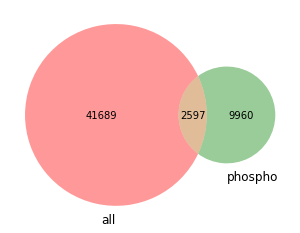

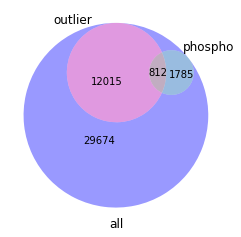

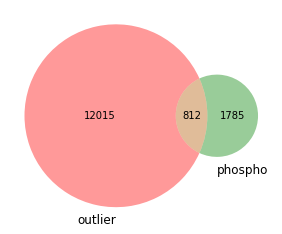

deep learning prediction


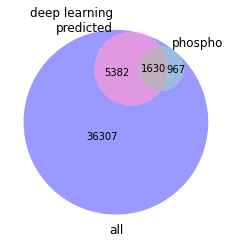

set_size: 44286, number_of_targets_in_set: 2597, number_of_draws: 7012, number_of_successes: 1630
0.0
combined deep learning & modpep prediction


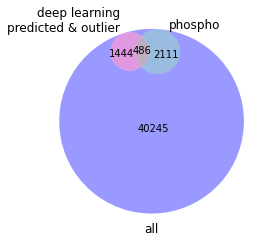

set_size: 44286, number_of_targets_in_set: 2597, number_of_draws: 1930, number_of_successes: 486
1.79654790628884e-179


In [20]:
import pandas as pd
outlier_filterer = aqoutlier.OutlierPeptideFilterConfigs(quality_score_quantile=1, num_mainclust_peptides_quantile=1, protnormed_fc_quantile=1)
outlier_peps_filtered = aqoutlier.OutlierPeptideFilterer(outlier_loader.outlier_peptides, outlier_filterer.filterconfigs).get_filtered_outlier_peptide_list()

import matplotlib_venn
import anytree
import matplotlib.pyplot as plt

outlier_peptides = {x.peptide_sequence for x in outlier_peps_filtered}
#outlier_peptides = outlier_peptides.intersection(predicted_phosphoprone_sequences)
modified_peptides = set(ptm_loader._pepname2modpep.keys())
modified_peptides = modified_peptides_all_in_dataset


all_peptides = set([x.name for x in anytree.findall(condpairtree_proteome, filter_=lambda x : getattr(x,"type", "") == 'seq', maxlevel=3)])




M = len(all_peptides) #set size
n = len(all_peptides.intersection(modified_peptides)) #number of targets in set
N = len(outlier_peptides) #number of draws from the set
k = len(all_peptides.intersection(modified_peptides).intersection(outlier_peptides)) #number of successes
p = perform_hypergeometric_test(M, n, N, k)
print(p)


matplotlib_venn.venn2([all_peptides, modified_peptides], ["all", "phospho"])
plt.savefig("venn_all_peptides_modified.pdf")
plt.show()


matplotlib_venn.venn3([outlier_peptides, modified_peptides.intersection(all_peptides), all_peptides], ["outlier", "phospho", "all"])


plt.savefig("venn_outlier_modified_all.pdf")
plt.show()

matplotlib_venn.venn2([outlier_peptides, modified_peptides.intersection(all_peptides)], ["outlier", "phospho"])
plt.savefig("venn_outlier_modified.pdf")
plt.show()


print("deep learning prediction")


matplotlib_venn.venn3([predicted_phosphoprone_sequences.intersection(all_peptides), modified_peptides.intersection(all_peptides), all_peptides ], 
                      ["deep learning\npredicted", "phospho", "all"])
plt.show()
p = perform_hypergeometric_test(set_size=len(all_peptides), number_of_targets_in_set=len(modified_peptides.intersection(all_peptides)),
                                number_of_draws= len(predicted_phosphoprone_sequences.intersection(all_peptides)), 
                                number_of_successes=len(predicted_phosphoprone_sequences.intersection(all_peptides).intersection(modified_peptides)))
print(p)


print("combined deep learning & modpep prediction")


matplotlib_venn.venn3([predicted_phosphoprone_sequences.intersection(all_peptides).intersection(outlier_peptides), 
                       modified_peptides.intersection(all_peptides), all_peptides ], 
                      ["deep learning\npredicted & outlier", "phospho", "all"])
plt.show()
p = perform_hypergeometric_test(set_size=len(all_peptides), number_of_targets_in_set=len(modified_peptides.intersection(all_peptides)),
                                number_of_draws= len(predicted_phosphoprone_sequences.intersection(all_peptides).intersection(outlier_peptides)), 
                                number_of_successes=len(predicted_phosphoprone_sequences.intersection(all_peptides).intersection(modified_peptides).intersection(outlier_peptides)))
print(p)



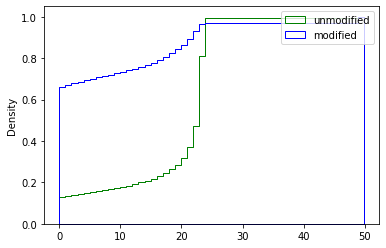

In [41]:
import seaborn as sns

scores_outlier_peptides = -np.log2([SEQ2PHOSPHOPRONE_SCORE.get(x, 1e-15) for x in outlier_peptides])
scores_modified_peptides = -np.log2([SEQ2PHOSPHOPRONE_SCORE.get(x, 1e-15) for x in modified_peptides])
scores_all_peptides = -np.log2([SEQ2PHOSPHOPRONE_SCORE.get(x,  1e-15) for x in all_peptides if x not in modified_peptides])

fig, ax = plt.subplots()

# Draw the histograms
sns.histplot(scores_all_peptides, ax=ax, bins=50, label='unmodified', color='green', stat='density', cumulative=True, element='step', alpha = 0)
sns.histplot(scores_modified_peptides, ax=ax, bins=50, label='modified', color='blue', stat='density', cumulative=True, element='step', alpha = 0)
ax.legend()


## plot protein fc strengths


/Users/constantin/opt/anaconda3/envs/alphaquant/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

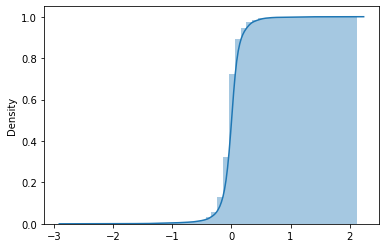

In [10]:
#histogram plot seaborn
import seaborn as sns
import matplotlib.pyplot as plt

protein_fc = [x.fc for x in condpairtree_proteome.children]

#cumulative distribution plot
sns.distplot(protein_fc, hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True))


pval is 0.7152668220856091
correlation is -0.07213818224226742


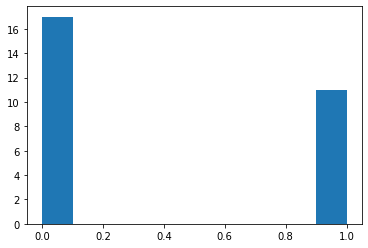

17 same, 11 opposite


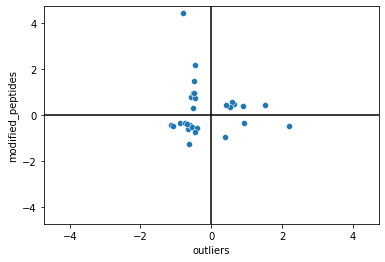

In [11]:
import matplotlib.pyplot as plt

quality_quantile = 1
filterconfigs = aqoutlier.ComplementedClusterFilterConfigs(ptm_abs_normfc_quantile=0.5, outlier_abs_normfc_quantile=0.3, outlier_quality_quantile=quality_quantile,modpep_quality_quantile=quality_quantile, ptm_absfc_quantile=1,number_mainclustpeps_quantile=0.4).filterconfigs


c_evaluator = aqoutlier.ComplementedClusterEvaluator(complemented_clusterloader,filterconfigs)
corr = c_evaluator.calculate_correlation()
print(f"correlation is {corr}")
ax = plt.axes()
c_evaluator.compare_regulation_directions(ax)

plt.show()

ax = plt.axes()
c_evaluator.scatter_fold_changes(ax)



#ax.set_xlim(-3, 3)
#ax.set_ylim(-3, 3)
plt.show()

28
Opposite sign: 7
Same sign: 13


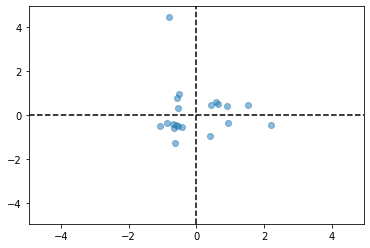

In [12]:
filtered_clusters = aqoutlier.ComplementedClusterFilterer(complemented_clusterloader, filterconfigs).get_filtered_complemented_clusters()
print(len(filtered_clusters))

fcs_clust1 = [x.outlier_peptide.protnormed_fc for x in filtered_clusters if x.outlier_peptide.peptide_sequence in predicted_phosphoprone_sequences]
fcs_clust2 = [x.modified_peptide.protnormed_fc for x in filtered_clusters if x.outlier_peptide.peptide_sequence in predicted_phosphoprone_sequences]

#scatterplot
plt.scatter(fcs_clust1, fcs_clust2, alpha=0.5)
#add vertical and horizontal lines
plt.axvline(0, color='black', linestyle='--')
plt.axhline(0, color='black', linestyle='--')
#set x and y limits to be the same
max_val = max(max(fcs_clust1), max(fcs_clust2))+0.5
plt.xlim(-max_val, max_val)
plt.ylim(-max_val, max_val)


#count fcs with opposite sign
opposite_sign = [x for x in zip(fcs_clust1, fcs_clust2) if x[0]*x[1] <= 0]
#same sign
same_sign = [x for x in zip(fcs_clust1, fcs_clust2) if x[0]*x[1] > 0]

print("Opposite sign: %s" % len(opposite_sign))
print("Same sign: %s" % len(same_sign))

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
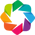

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
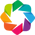

In [13]:
import alphaquant.visualizations as aqplot
import alphaquant.outlier_scoring as aqoutlier


outlier_handler = aqoutlier.OutlierHandler(results_dir = RESULTS_DIR_PROTEOME, cond1 = CONDPAIR[0], cond2 = CONDPAIR[1])
diffclust_list = outlier_handler.get_diffclust_overview_list()

quantification_info = aqplot.CondpairQuantificationInfo().init_by_loading_tables(cond1 = CONDPAIR[0], cond2 = CONDPAIR[1], results_dir = RESULTS_DIR_PROTEOME, samplemap=SAMPLEMAP_PROTEOME)
pepdf_getter = aqplot.PeptideIntensityDataframeGetter(quantification_info=quantification_info)


In [14]:

quantification_info_ptms = aqplot.CondpairQuantificationInfo().init_by_loading_tables(cond1 = CONDPAIR[0], cond2 = CONDPAIR[1], results_dir = RESULTS_DIR_PHOSPHO, samplemap=SAMPLEMAP_PHOSPHO)
pepdf_getter_ptm = aqplot.PeptideIntensityDataframeGetter(quantification_info=quantification_info_ptms)


In [15]:
import importlib
import alphaquant
importlib.reload(alphaquant)

all_peptides = anytree.findall(condpairtree_proteome, filter_= lambda x : getattr(x, 'type', '')== 'seq', maxlevel=5)
all_predscore = [x.predscore for x in all_peptides]

plt.hist(all_predscore)

AttributeError: 'AnyNode' object has no attribute 'predscore'

SEQ_QELGSPEER_
outlier fc -0.5802265125856022
modified fc 0.755865153529496


outlier protnormed -0.5633652919826028
modified protnormed 0.7727263741324955
True


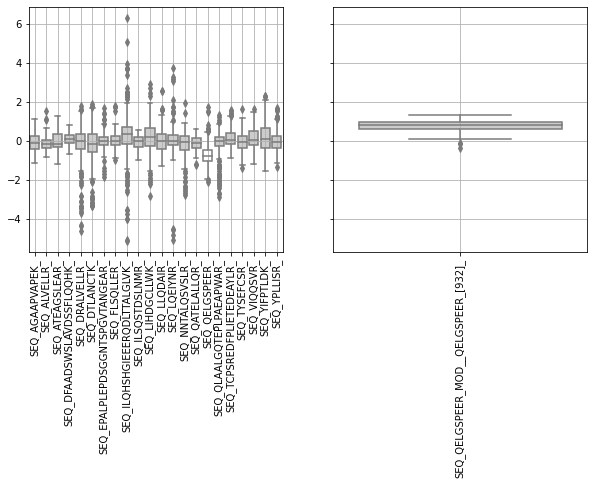

SEQ_SISSPSVSSETMDK_
outlier fc -0.490938768692192
modified fc 0.9538823120215364


outlier protnormed -0.5055768868369339
modified protnormed 0.9392441938767945
True


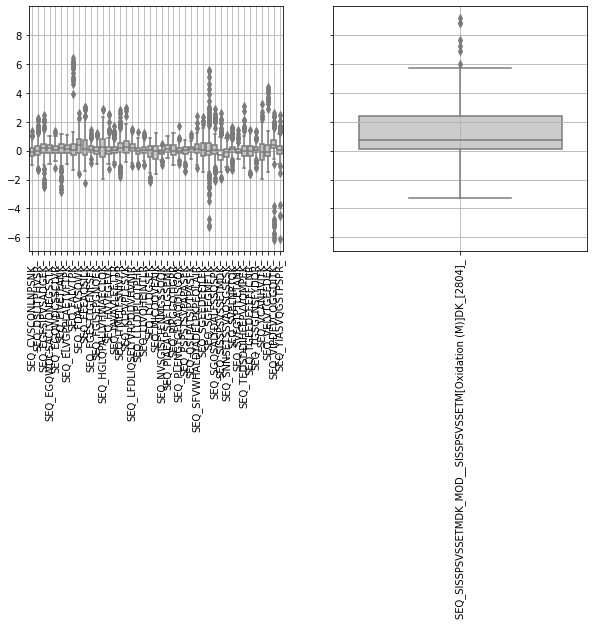

SEQ_NKPSDLGTK_
outlier fc -0.4321503815006523
modified fc 1.5354740200798365


outlier protnormed -0.5004307239162232
modified protnormed 1.4671936776642656
True


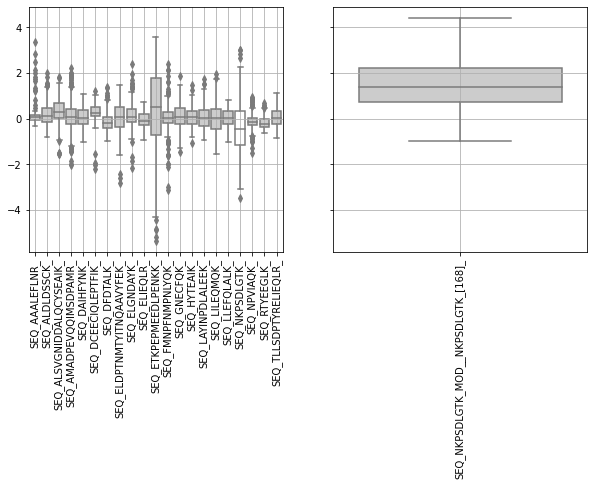

SEQ_TNSPGFQK_
outlier fc -0.6576084204469046
modified fc -0.5949959794050071


outlier protnormed -0.6555021216585798
modified protnormed -0.5928896806166823
False


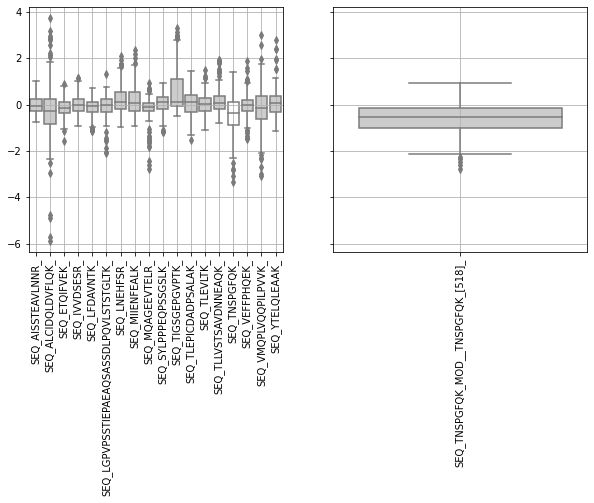

SEQ_SALFSESQK_
outlier fc -0.4508322077332987
modified fc 2.191247998168082


outlier protnormed -0.4725110403743367
modified protnormed 2.169569165527044
True


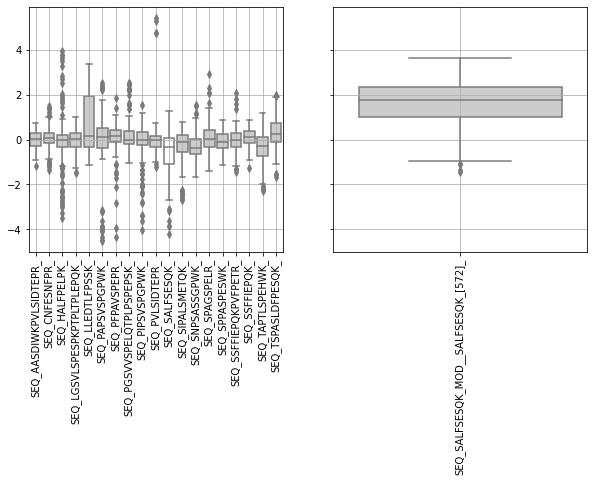

SEQ_TASFSESR_
outlier fc -0.485693317429738
modified fc -0.33356990090198907


outlier protnormed -0.5970902311045285
modified protnormed -0.4449668145767796
False


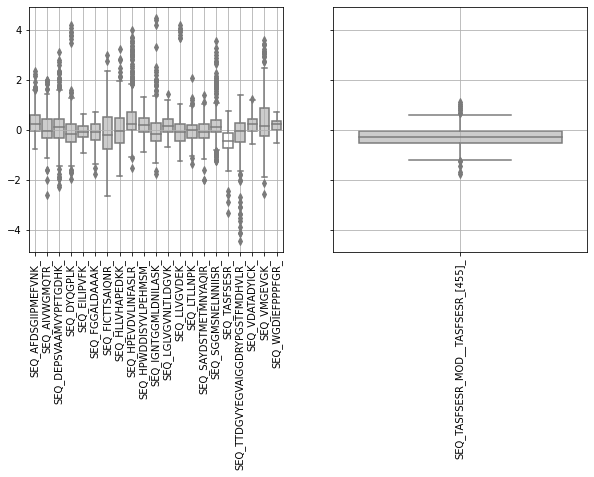

SEQ_TSGETTQTHTEPTGDSK_
outlier fc -1.1067478021301418
modified fc -0.41430858726541175


outlier protnormed -1.125244994016732
modified protnormed -0.4328057791520018
False


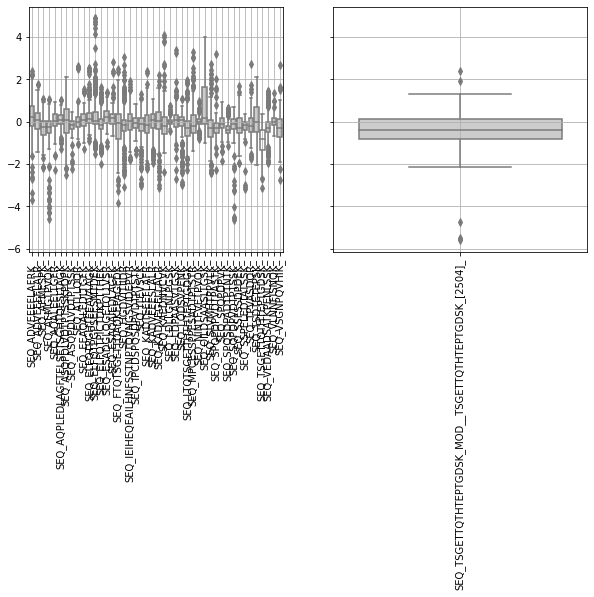

SEQ_PGNPPAEIGQNISSNSSASILESK_
outlier fc -0.47955809332380783
modified fc 0.7266276398133877


outlier protnormed -0.47128393136750335
modified protnormed 0.7349018017696922
True


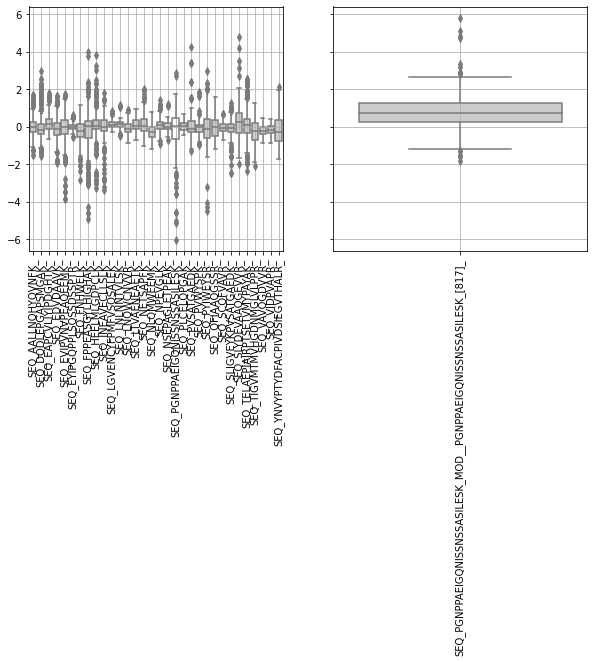

SEQ_SVGGSGGGSFGDNLVTR_
outlier fc -0.7915404099709633
modified fc 4.465489572343018


outlier protnormed -0.8116277668401021
modified protnormed 4.445402215473879
True


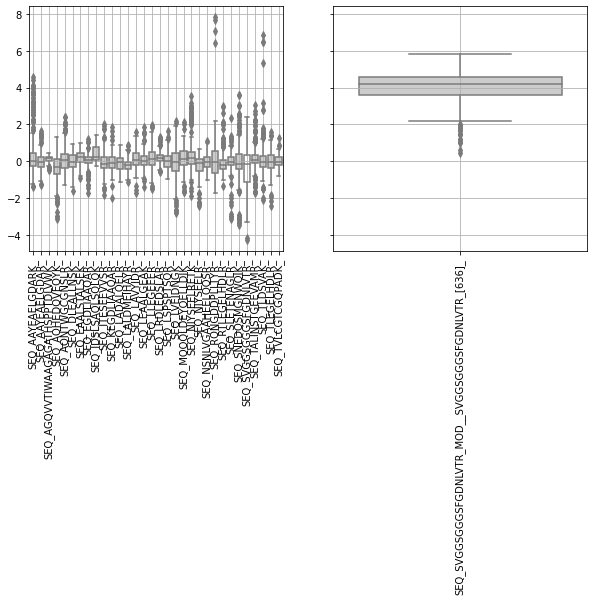

SEQ_VSLEPHQGPGTPESK_
outlier fc -0.5735497142610142
modified fc -0.5330139031737572


outlier protnormed -0.5545363542263202
modified protnormed -0.5140005431390632
False


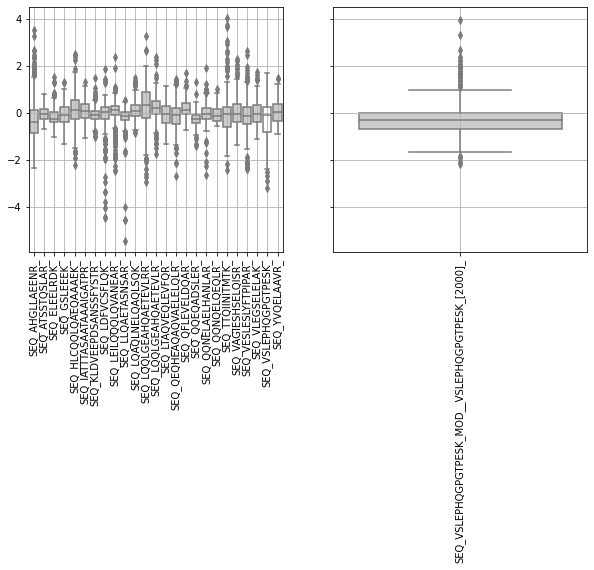

SEQ_PGTPPIAGR_
outlier fc -0.3641448094578075
modified fc -0.5184365848886929


outlier protnormed -0.4099925765044744
modified protnormed -0.5642843519353599
False


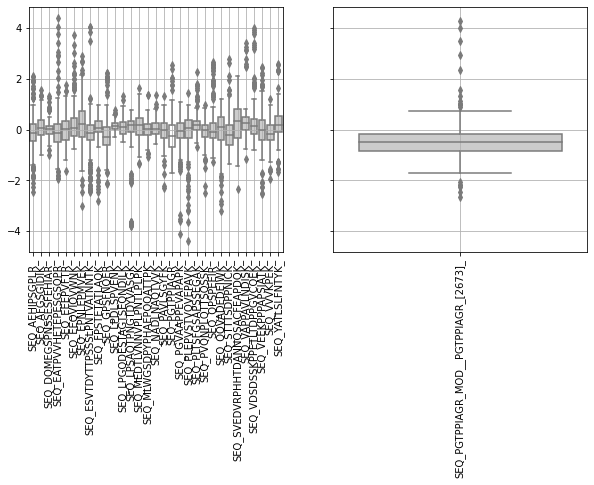

SEQ_DSDQVAQSDGEESPAAEEQLLGEHIK_
outlier fc 0.6490958711980078
modified fc 0.5054939646614407


outlier protnormed 0.646410132944145
modified protnormed 0.5028082264075779
False


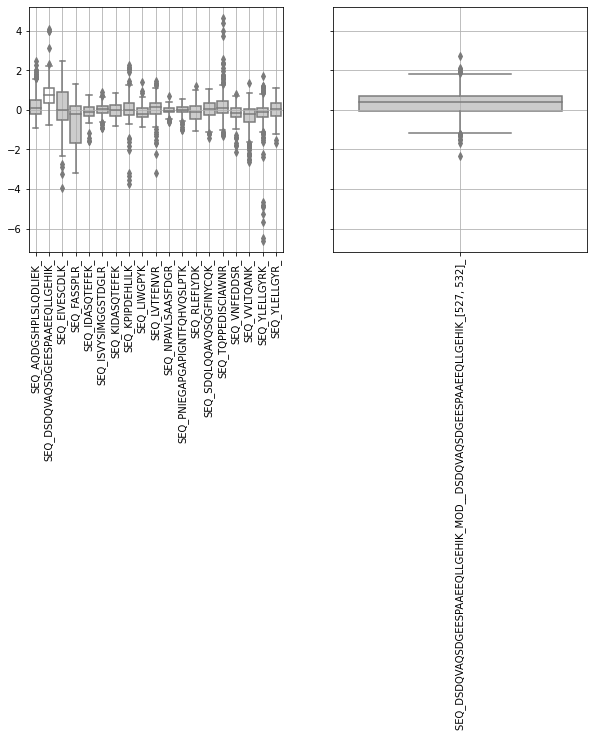

SEQ_QPTVASPAESDEENRQK_
outlier fc -0.8617465224851769
modified fc -0.33387343051555485


outlier protnormed -0.8735130032650509
modified protnormed -0.3456399112954288
False


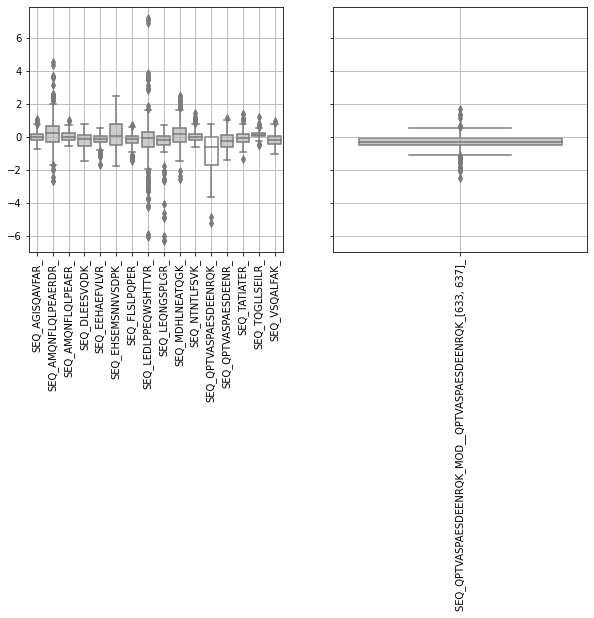

SEQ_HADHSSLTLGSGSSTTR_
outlier fc -0.7995963599065179
modified fc -0.4131217344361149


outlier protnormed -0.7513837453717194
modified protnormed -0.36490911990131636
False


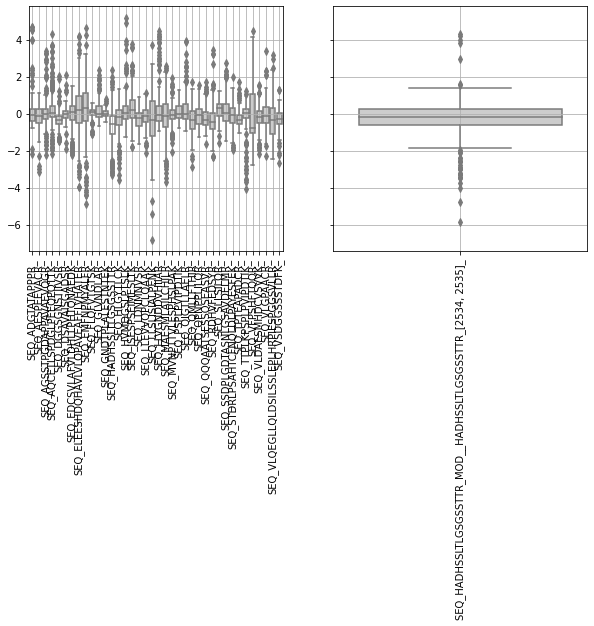

SEQ_VGSTENIK_
outlier fc -0.7217971379531672
modified fc -0.42934068088124544


outlier protnormed -0.682447596795473
modified protnormed -0.38999113972355115
False


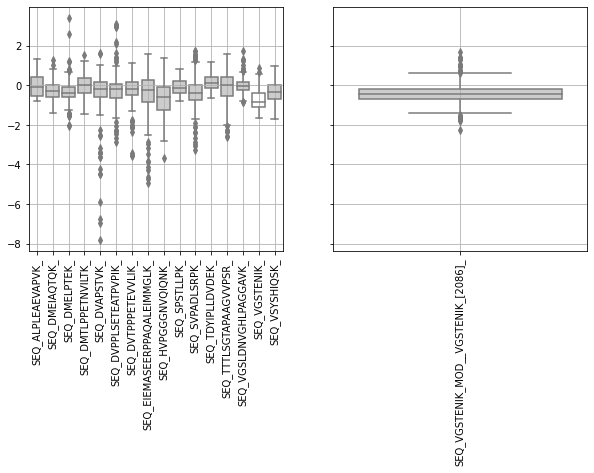

SEQ_DISSSLNSLADSNAR_
outlier fc 0.6214323425032298
modified fc 0.6203913306096969


outlier protnormed 0.5812956915841936
modified protnormed 0.5802546796906607
False


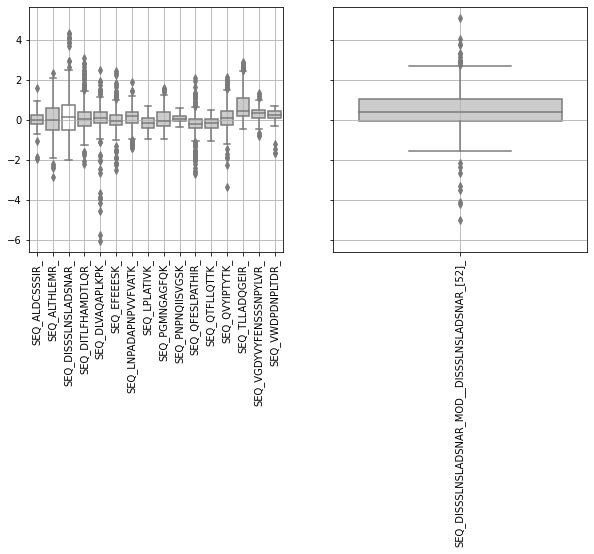

SEQ_ADVQSIIGLQR_
outlier fc 0.4970369905956904
modified fc 0.3103169117867315


outlier protnormed 0.5307360399209613
modified protnormed 0.3440159611120024
False


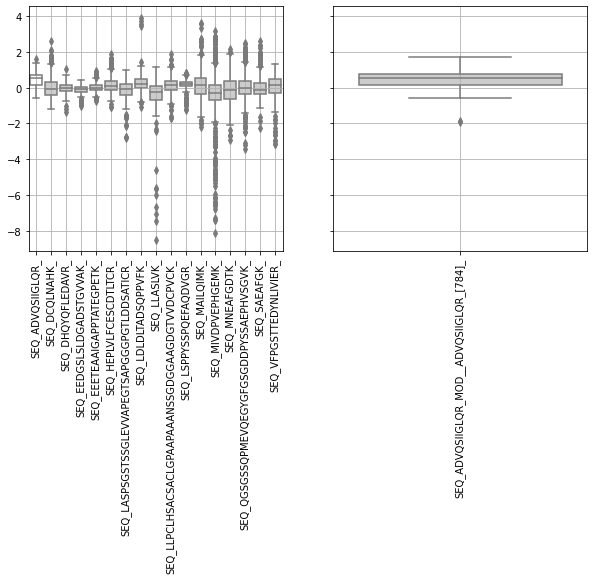

SEQ_DGDGVPGGGPLSPAR_
outlier fc -0.5197363013362407
modified fc 0.3315058067477685


outlier protnormed -0.5297579581277451
modified protnormed 0.3214841499562642
True


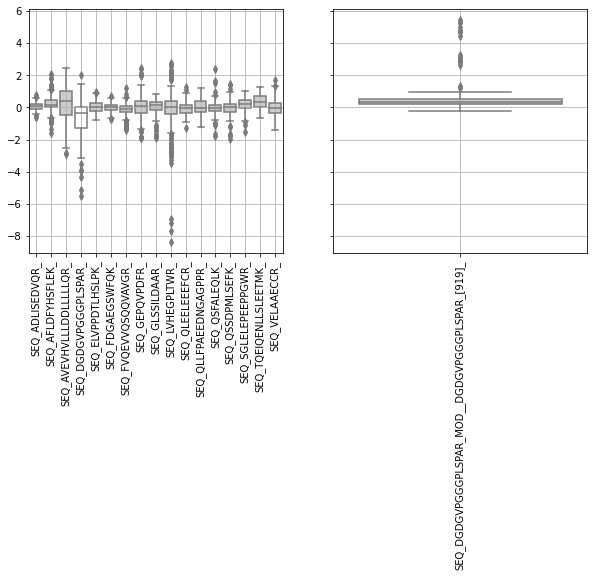

SEQ_NQGGYGGSSSSSSYGSGR_
outlier fc 2.179670841401301
modified fc -0.4724023322251718


outlier protnormed 2.1955034594242293
modified protnormed -0.4565697142022432
True


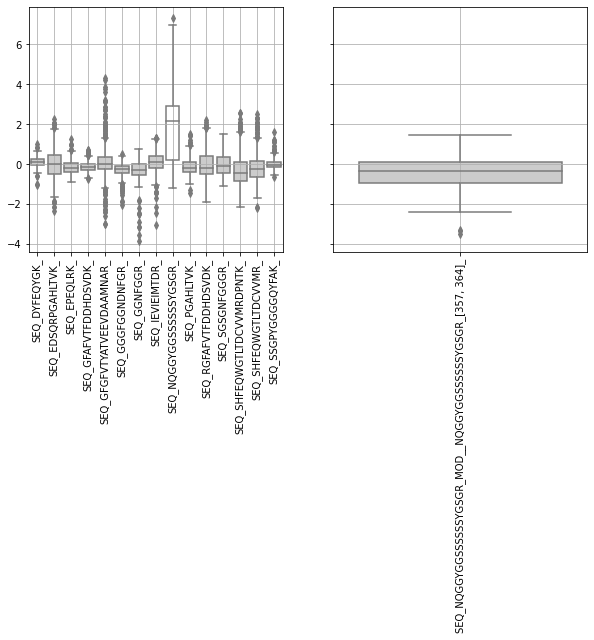

SEQ_SEDGVEGDLGETQSR_
outlier fc 0.9206387843734765
modified fc -0.3752400549281778


outlier protnormed 0.9344551041072028
modified protnormed -0.3614237351944515
True


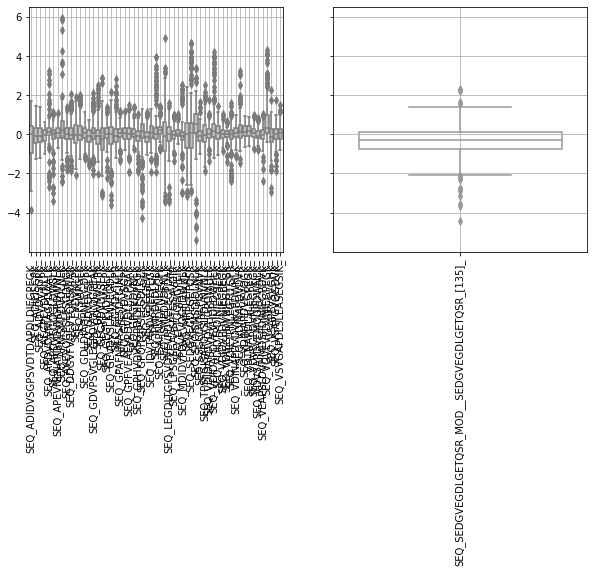

SEQ_IEDVGSDEEDDSGK_
outlier fc 1.5458522451251868
modified fc 0.47812792459427467


outlier protnormed 1.5185603922192203
modified protnormed 0.4508360716883082
False


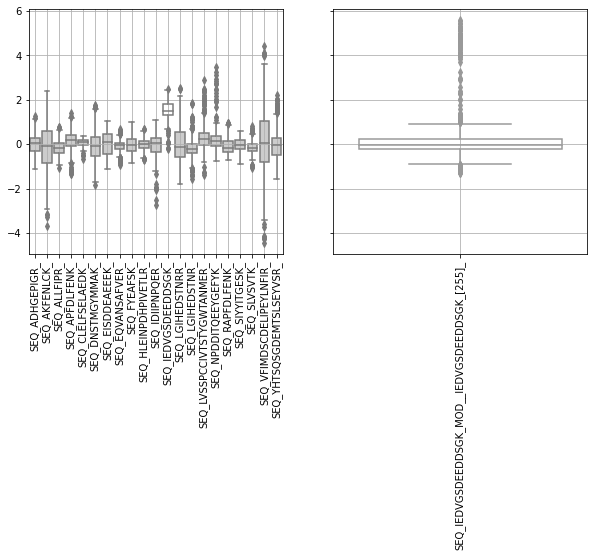

SEQ_RSQEDEISSPVNK_
outlier fc 0.4283607863771537
modified fc -0.91606636522262


outlier protnormed 0.400351234300379
modified protnormed -0.9440759172993947
True


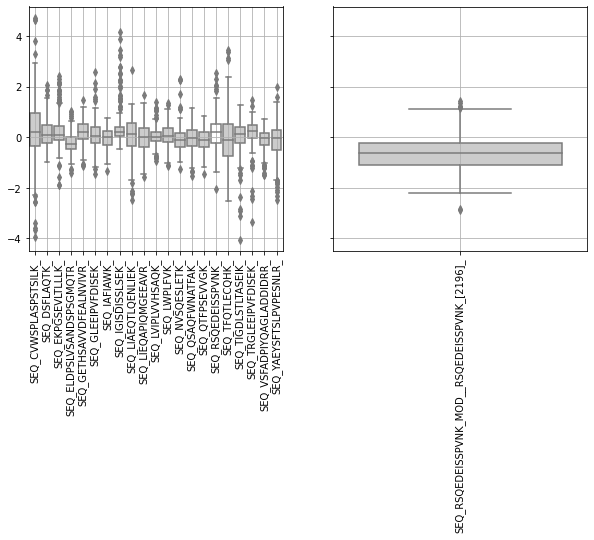

SEQ_VAVATPAK_
outlier fc -0.6175621309706193
modified fc -1.268125804987332


outlier protnormed -0.6229708823066373
modified protnormed -1.2735345563233502
False


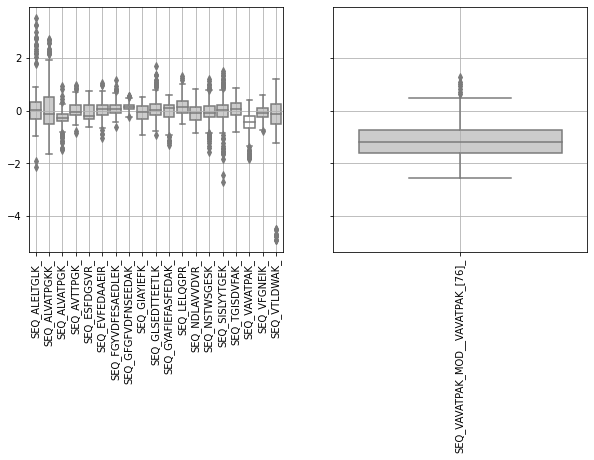

SEQ_EEESIEGEK_
outlier fc -0.4779211779747674
modified fc -0.7619257563020433


outlier protnormed -0.4490437377474765
modified protnormed -0.7330483160747524
False


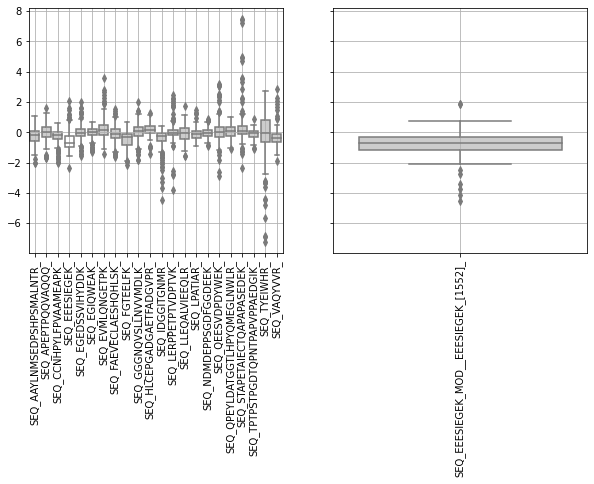

SEQ_TLVLSNLSYSATEETLQEVFEK_
outlier fc 0.4341829587574344
modified fc 0.4601632356212739


outlier protnormed 0.42877420742141636
modified protnormed 0.4547544842852559
False


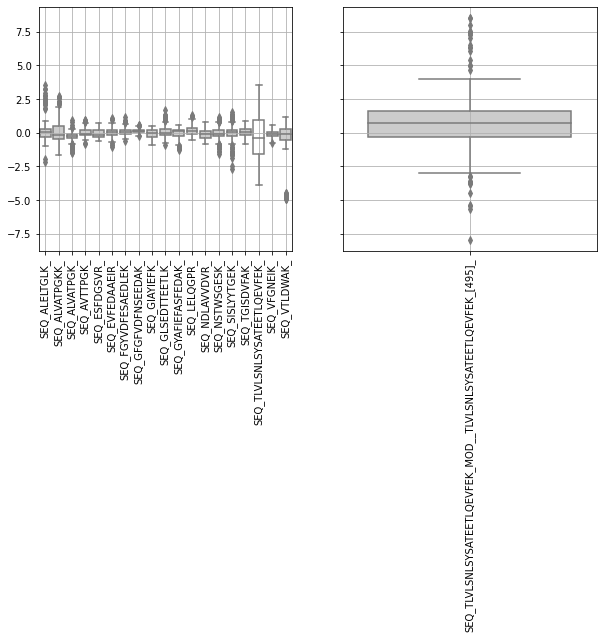

SEQ_GEDSAEETEAK_
outlier fc -1.0946864923933668
modified fc -0.494778825458415


outlier protnormed -1.075877254171992
modified protnormed -0.47596958723704025
False


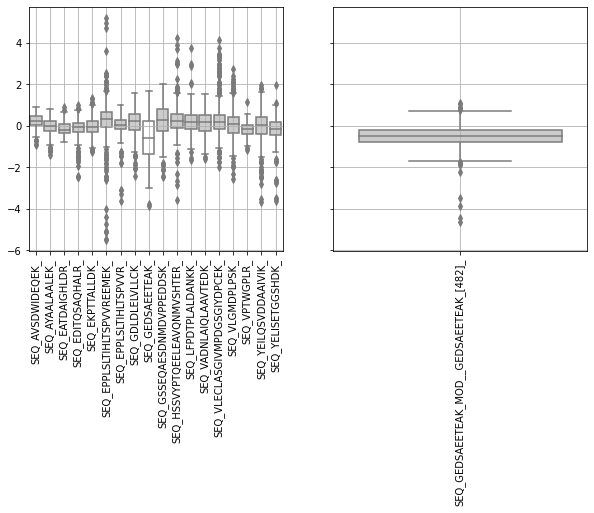

SEQ_TQASSSFQDSSQPAGK_
outlier fc -0.47376671703965734
modified fc 0.955303961010862


outlier protnormed -0.48475029306686945
modified protnormed 0.9443203849836499
True


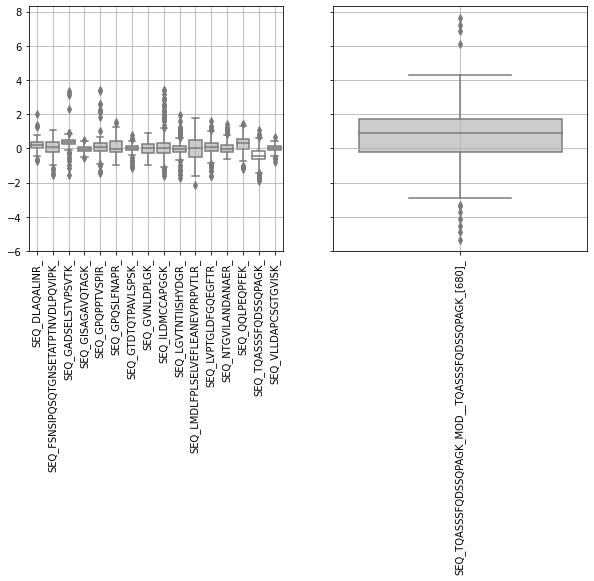

SEQ_SEEHHLYSNPIK_
outlier fc 0.8196799030534998
modified fc 0.3151221067194878


outlier protnormed 0.8992084743547497
modified protnormed 0.3946506780207377
False


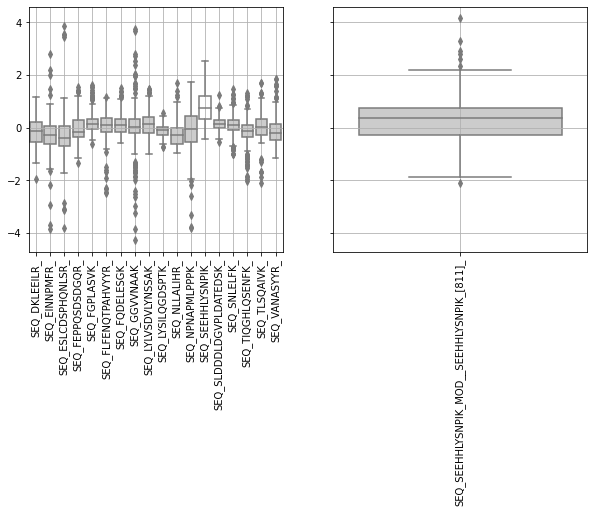

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Some example data to display
x = np.linspace(0, 2 * np.pi, 400)
y = np.sin(x ** 2)

def plot_complemented_cluster_condpairinfo(complemented_cluster,diffclust_list):
    fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, sharex=False,figsize=(10,5))

    plot_peptides_of_protein(complemented_cluster,diffclust_list, ax1)
    plot_phospho_peptides(complemented_cluster, ax2)
    plt.subplots_adjust(bottom = 0.2)
    ax1.grid(True)
    ax2.grid(True)
    return fig



def plot_peptides_of_protein(complemented_cluster, diffclust_list, ax):
    condpairinfo_to_plot  = filter_relevant_condpairinfo_for_complemented_cluster(diffclust_list, complemented_cluster)
    peptides_to_plot = condpairinfo_to_plot.mainclust_peptide_names + [complemented_cluster.outlier_peptide.peptide_sequence]
    melted_plot_df = pepdf_getter.get_melted_ion_intensity_table_peptide_subset(protein=condpairinfo_to_plot.protein_name,peptides_to_plot=peptides_to_plot, specified_level="seq")
    fcplotter = aqplot.IonFoldChangePlotter(melted_df=melted_plot_df, condpair = CONDPAIR)
    ax_protein = fcplotter.plot_fcs_predscore_relative_strength(ax=ax)
    return ax_protein


def plot_phospho_peptides(complemented_cluster, ax):
    peptides_to_plot =  [complemented_cluster.modified_peptide.modified_sequence]
    melted_plot_df = pepdf_getter_ptm.get_melted_ion_intensity_table_peptide_subset(protein=complemented_cluster.modified_peptide.protein_name,peptides_to_plot=peptides_to_plot, specified_level="mod_seq")
    fcplotter = aqplot.IonFoldChangePlotter(melted_df=melted_plot_df, condpair = CONDPAIR)
    ax_ptm = fcplotter.plot_fcs_predscore_relative_strength(ax=ax)
    return ax_ptm


def filter_relevant_condpairinfo_for_complemented_cluster(diffclust_list, complemented_cluster):
    return filter(lambda x : complemented_cluster.outlier_peptide.peptide_sequence in x.outlier_peptide_names ,diffclust_list).__next__()



compclusts = aqoutlier.ComplementedClusterFilterer(complemented_clusterloader,filterconfigs).get_filtered_complemented_clusters()

count = 0
for clust in filtered_clusters:
    print(clust.outlier_peptide.peptide_sequence)
    print(f"outlier fc {clust.outlier_peptide.fc}")
    print(f"modified fc {clust.modified_peptide.fc}")
    print("\n")
    print(f"outlier protnormed {clust.outlier_peptide.protnormed_fc}")
    print(f"modified protnormed {clust.modified_peptide.protnormed_fc}")
    print(np.sign(clust.outlier_peptide.protnormed_fc) == -np.sign(clust.modified_peptide.protnormed_fc))
    fig = plot_complemented_cluster_condpairinfo(clust, diffclust_list)
    #fig.show()
    plt.show()
    count+=1
    


In [ ]:
outlier_handler = aqoutlier.OutlierHandler(results_dir = results_dir, cond1 = condpair[0], cond2 = condpair[1])
diffcluster_list = outlier_handler.get_diffclust_overview_list()

In [17]:
import alphaquant.outlier_scoring as aqoutlier

dcfilt = aqoutlier.DiffClusterFilterer(diffclust_list, aqoutlier.DiffClusterFilterConfig(fcdiff_quantile=0.001, quality_score_quantile=1, num_mainclust_peptides_quantile=1).filterconfigs)


filtlist = dcfilt.get_filtered_diffclust_list()
print(len(filtlist))


4


(array([6.2000e+01, 3.8900e+02, 6.4000e+01, 2.2000e+01, 1.7000e+01,
        3.0000e+00, 3.3600e+02, 6.1254e+04, 0.0000e+00, 1.0000e+00]),
 array([-0.29464298, -0.08803172,  0.11857953,  0.32519079,  0.53180205,
         0.7384133 ,  0.94502456,  1.15163582,  1.35824707,  1.56485833,
         1.77146959]),
 <BarContainer object of 10 artists>)

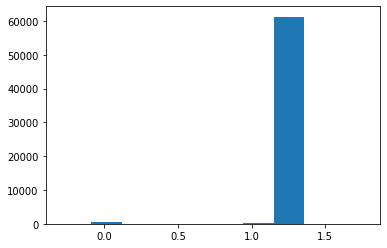

In [ ]:
all_peptides = anytree.findall(condpairtree_proteome, filter_= lambda x : getattr(x, 'type', '')== 'mod_seq_charge', maxlevel=5)
all_predscore = [x.predscore for x in all_peptides]

plt.hist(all_predscore)


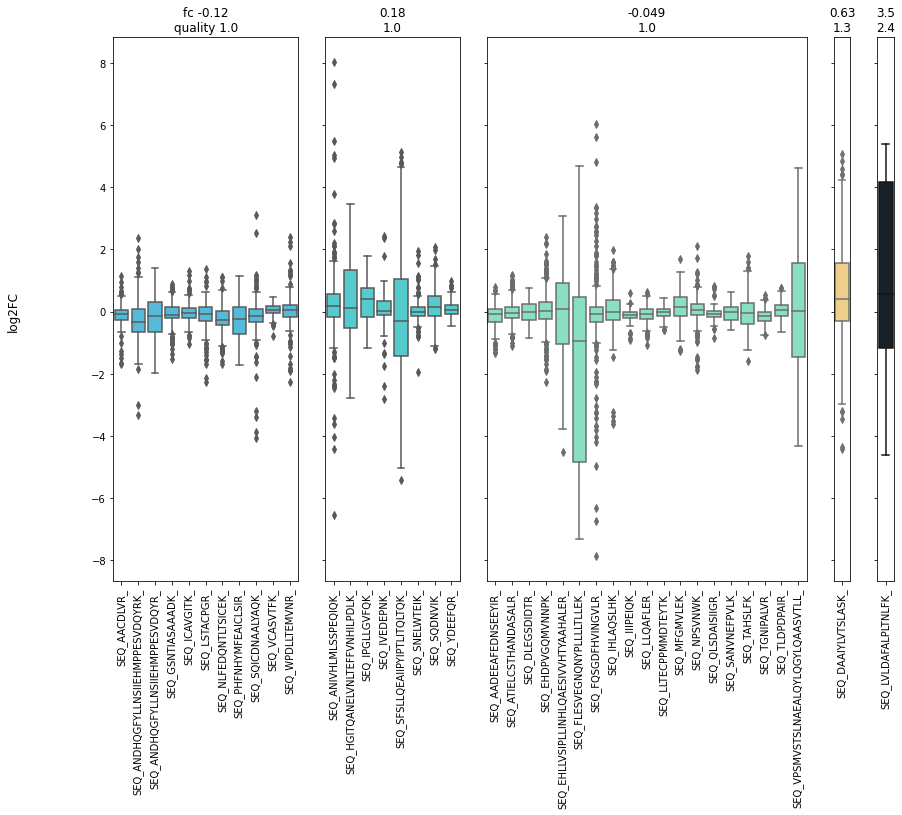

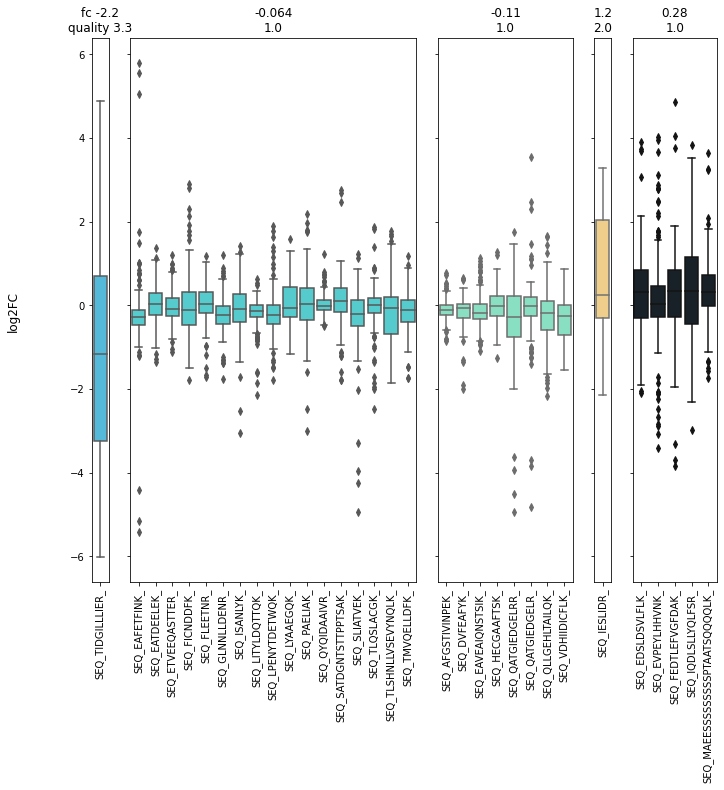

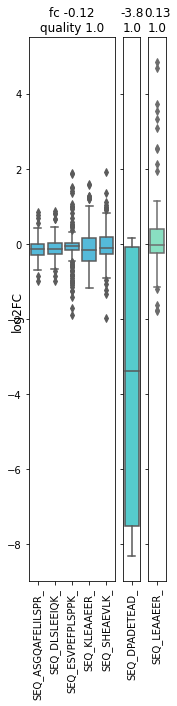

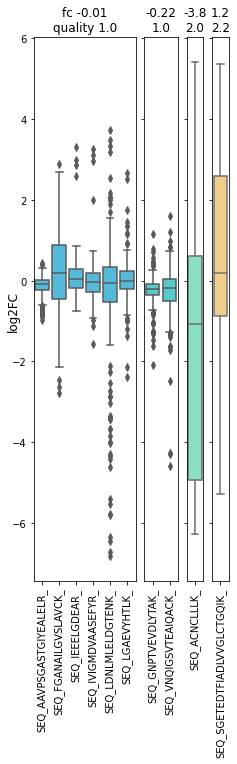

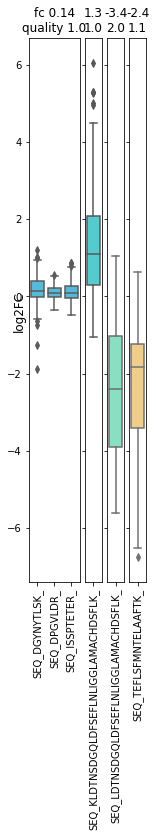

In [ ]:


for protnode in aqoutlier.ProtNodeRetriever.get_protnodes_from_diffclust_list(condpairtree_proteome, filtlist):
    pcplotter = ProteinClusterPlotter(protnode,condpair, pepdf_getter)
    pcplotter.plot_all_clusters_for_protein()